In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from keras.metrics import mse
import matplotlib.pyplot as plt
from keras.backend import set_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, UpSampling2D, Input, Lambda, multiply, Input, concatenate
from keras.layers import LeakyReLU
from PIL import Image
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def ChangeImage(image, dim=32):
    x_cutting = image.size[0] - image.size[0] % dim
    y_cutting = image.size[1] - image.size[1] % dim

    a = (image.size[0] - x_cutting) // 2
    b = (image.size[1] - y_cutting) // 2
    c = (image.size[0] + x_cutting) // 2
    d = (image.size[1] + y_cutting) // 2

    cropped_image = img_to_array(image.crop([a,b,c,d]))
    cropped_image = (np.expand_dims(cropped_image, axis=0).astype('float32'))/255
    return cropped_image

In [ ]:
def add_noise(image, sigma):
    noise = np.clip(image + np.random.normal(scale=sigma, size=image.shape), 0, 1).astype(np.float32)
    return noise

In [ ]:
class Hourglass:
    def __init__(self, input_size, input_channel, output_channel, nu, nd, ns, ku, kd, ks, upsample_type='bilinear'):
        self.in_size = input_size
        self.in_channel = input_channel
        self.out_channel = output_channel
        self.nu = nu
        self.nd = nd
        self.ns = ns
        self.ku = ku
        self.kd = kd
        self.ks = ks
        self.upsample_type = upsample_type
        self.use_bias = True

    def up_sample(self, x, size=2):
        index = x.shape
        new_w = int(round(index[1] * size))
        new_h = int(round(index[2] * size))
        return tf.image.resize(x, [new_w, new_h], method=tf.image.ResizeMethod.BILINEAR)

    def down(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=2, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    
    def skip(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    def up(self, x, n, k, upsample_mode, use_bias=True):
        x = BatchNormalization()(x)
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(n, 1, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = self.up_sample(x, 2)
        return x
    
    def model_structure(self):
        width, height = self.in_size
        input = Input((width, height, self.in_channel))
        x = input
        n = 5
        skips = []
        x = self.down(x, self.nd[0], self.kd[0], self.use_bias)
        if self.ns[0] != 0:
            skip = self.skip(x, self.ns[0], self.ks[0], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[1], self.kd[1], self.use_bias)
        if self.ns[1] != 0:
            skip = self.skip(x, self.ns[1], self.ks[1], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[2], self.kd[2], self.use_bias)
        if self.ns[2] != 0:
            skip = self.skip(x, self.ns[2], self.ks[2], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[3], self.kd[3], self.use_bias)
        if self.ns[3] != 0:
            skip = self.skip(x, self.ns[3], self.ks[3], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[4], self.kd[4], self.use_bias)
        if self.ns[4] != 0:
            skip = self.skip(x, self.ns[4], self.ks[4], self.use_bias)
            skips.append(skip)

        x = self.up(x, self.nu[4], self.ku[4], self.upsample_type, self.use_bias)
        skips = skips[::-1]
        x = self.up(x, self.nu[3], self.ku[3],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[2]], axis=-1)
        x = self.up(x, self.nu[2], self.ku[2],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[3]], axis=-1)
        x = self.up(x, self.nu[1], self.ku[1],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[4]], axis=-1)
        x = self.up(x, self.nu[0], self.ku[0],self.upsample_type, self.use_bias)

        output = Conv2D(self.out_channel, 1, activation='sigmoid')(x)

        model = Model(inputs=input, outputs=output)
        return model

In [ ]:
def plot_losses(train_loss, image_title):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(image_title)
    # plt.figure(figsize=(10,10))
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.show()

In [ ]:
import os
import glob

folder_path = "./drive/MyDrive/SMAI_Project"  # replace with your folder path

file_list = []
for file_path in glob.glob(os.path.join(folder_path, "*")):
    file_list.append(file_path)
print(file_list)

['./drive/MyDrive/SMAI_Project/coastguard.png', './drive/MyDrive/SMAI_Project/bridge.png', './drive/MyDrive/SMAI_Project/face.png', './drive/MyDrive/SMAI_Project/comic.png', './drive/MyDrive/SMAI_Project/foreman.png', './drive/MyDrive/SMAI_Project/flowers.png', './drive/MyDrive/SMAI_Project/baboon.png', './drive/MyDrive/SMAI_Project/man.png', './drive/MyDrive/SMAI_Project/lenna.png', './drive/MyDrive/SMAI_Project/ppt3.png', './drive/MyDrive/SMAI_Project/monarch.png', './drive/MyDrive/SMAI_Project/zebra.png', './drive/MyDrive/SMAI_Project/barbara.png', './drive/MyDrive/SMAI_Project/pepper.png', './drive/MyDrive/SMAI_Project/coastguard', './drive/MyDrive/SMAI_Project/bridge', './drive/MyDrive/SMAI_Project/face', './drive/MyDrive/SMAI_Project/comic', './drive/MyDrive/SMAI_Project/foreman', './drive/MyDrive/SMAI_Project/flowers', './drive/MyDrive/SMAI_Project/baboon', './drive/MyDrive/SMAI_Project/man', './drive/MyDrive/SMAI_Project/lenna', './drive/MyDrive/SMAI_Project/ppt3', './drive/MyD

In [ ]:
def model_obj(x):
  b, w, h, c = x.shape

  ### build model
  layers = Hourglass((w, h), input_channel, c,
                        nu=[128, 128, 128, 128, 128],
                        nd=[128, 128, 128, 128, 128],
                        ns=[4, 4, 4, 4, 128],
                        ku=[3, 3, 3, 3, 3],
                        kd=[3, 3, 3, 3, 3],
                        ks=[1, 1, 1, 1, 1],
                        upsample_type='bilinear'
                        )
  return layers


---------------------------coastguard---------------------------


iteration no.: 0 ,loss : 0.111269
iteration no.: 500 ,loss : 0.013191
iteration no.: 1000 ,loss : 0.012257
iteration no.: 1500 ,loss : 0.011646
iteration no.: 2000 ,loss : 0.011225
iteration no.: 2500 ,loss : 0.010901
iteration no.: 3000 ,loss : 0.010592
iteration no.: 3500 ,loss : 0.010331
iteration no.: 4000 ,loss : 0.010162
iteration no.: 4500 ,loss : 0.009949
iteration no.: 5000 ,loss : 0.009872
iteration no.: 5500 ,loss : 0.009669
iteration no.: 6000 ,loss : 0.009584
iteration no.: 6500 ,loss : 0.009371
iteration no.: 7000 ,loss : 0.009270
iteration no.: 7500 ,loss : 0.009158
iteration no.: 8000 ,loss : 0.009049
iteration no.: 8500 ,loss : 0.008991
iteration no.: 9000 ,loss : 0.008889
iteration no.: 9500 ,loss : 0.008888
iteration no.: 10000 ,loss : 0.008747


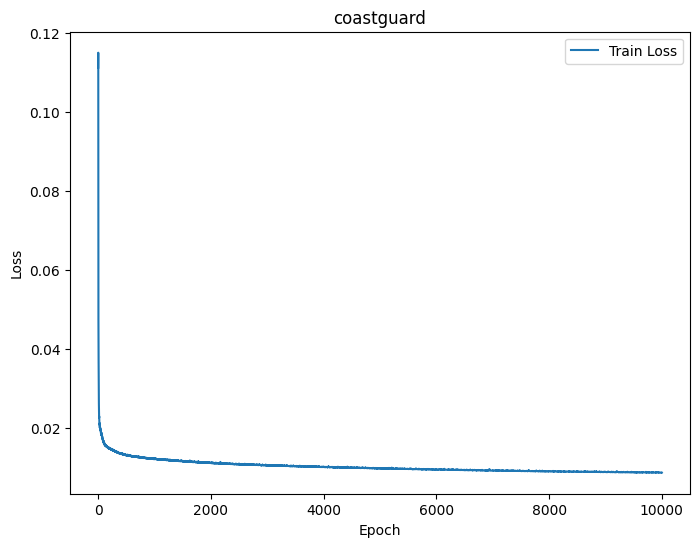


---------------------------bridge---------------------------


iteration no.: 0 ,loss : 0.095643
iteration no.: 500 ,loss : 0.016220
iteration no.: 1000 ,loss : 0.014218
iteration no.: 1500 ,loss : 0.013457
iteration no.: 2000 ,loss : 0.012809
iteration no.: 2500 ,loss : 0.012554
iteration no.: 3000 ,loss : 0.012153
iteration no.: 3500 ,loss : 0.011888
iteration no.: 4000 ,loss : 0.011794
iteration no.: 4500 ,loss : 0.011632
iteration no.: 5000 ,loss : 0.011503
iteration no.: 5500 ,loss : 0.011428
iteration no.: 6000 ,loss : 0.011255
iteration no.: 6500 ,loss : 0.011084
iteration no.: 7000 ,loss : 0.011001
iteration no.: 7500 ,loss : 0.010939
iteration no.: 8000 ,loss : 0.010828
iteration no.: 8500 ,loss : 0.010721
iteration no.: 9000 ,loss : 0.010766
iteration no.: 9500 ,loss : 0.010657
iteration no.: 10000 ,loss : 0.010658


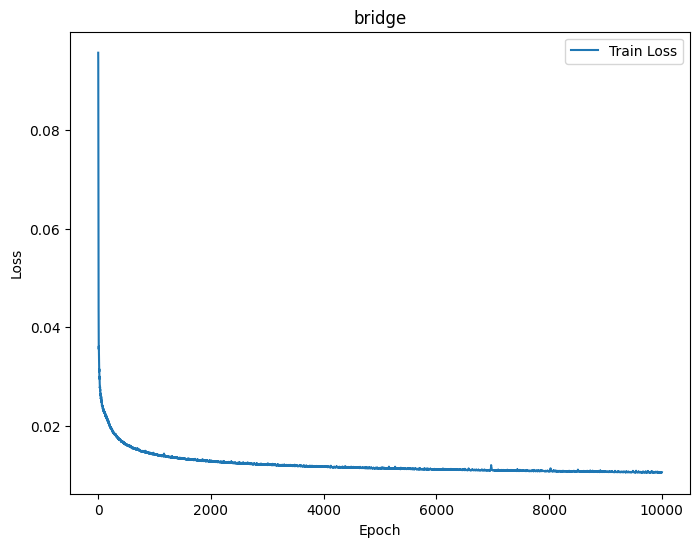


---------------------------face---------------------------


iteration no.: 0 ,loss : 0.125072
iteration no.: 500 ,loss : 0.009479
iteration no.: 1000 ,loss : 0.008898
iteration no.: 1500 ,loss : 0.008665
iteration no.: 2000 ,loss : 0.008441
iteration no.: 2500 ,loss : 0.008390
iteration no.: 3000 ,loss : 0.008186
iteration no.: 3500 ,loss : 0.008076
iteration no.: 4000 ,loss : 0.007973
iteration no.: 4500 ,loss : 0.007845
iteration no.: 5000 ,loss : 0.007741
iteration no.: 5500 ,loss : 0.007665
iteration no.: 6000 ,loss : 0.007575
iteration no.: 6500 ,loss : 0.007491
iteration no.: 7000 ,loss : 0.007435
iteration no.: 7500 ,loss : 0.007360
iteration no.: 8000 ,loss : 0.007277
iteration no.: 8500 ,loss : 0.007202
iteration no.: 9000 ,loss : 0.007160
iteration no.: 9500 ,loss : 0.007065
iteration no.: 10000 ,loss : 0.007018


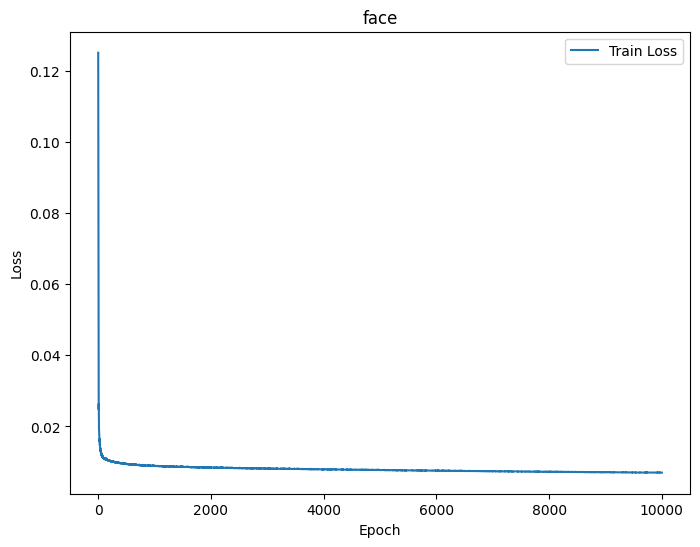


---------------------------comic---------------------------


iteration no.: 0 ,loss : 0.119886
iteration no.: 500 ,loss : 0.018010
iteration no.: 1000 ,loss : 0.015105
iteration no.: 1500 ,loss : 0.013807
iteration no.: 2000 ,loss : 0.013202
iteration no.: 2500 ,loss : 0.012361
iteration no.: 3000 ,loss : 0.011977
iteration no.: 3500 ,loss : 0.011617
iteration no.: 4000 ,loss : 0.011349
iteration no.: 4500 ,loss : 0.011088
iteration no.: 5000 ,loss : 0.010828
iteration no.: 5500 ,loss : 0.010736
iteration no.: 6000 ,loss : 0.010543
iteration no.: 6500 ,loss : 0.010386
iteration no.: 7000 ,loss : 0.010262
iteration no.: 7500 ,loss : 0.010169
iteration no.: 8000 ,loss : 0.010068
iteration no.: 8500 ,loss : 0.009988
iteration no.: 9000 ,loss : 0.009925
iteration no.: 9500 ,loss : 0.009943
iteration no.: 10000 ,loss : 0.009777


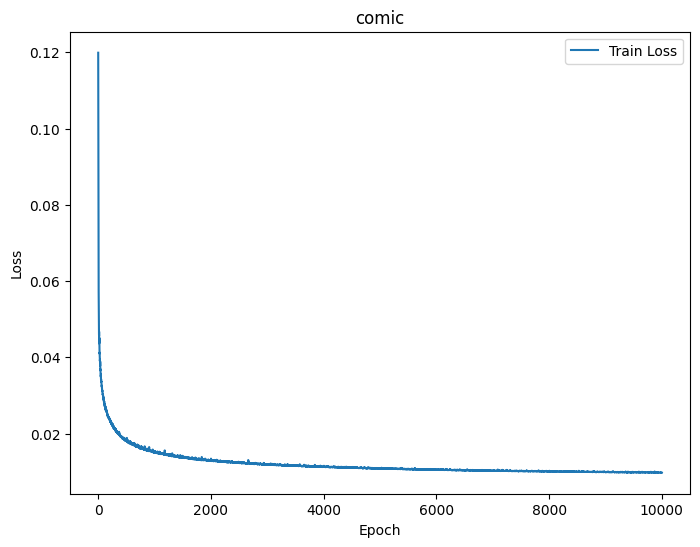


---------------------------foreman---------------------------


iteration no.: 0 ,loss : 0.146424
iteration no.: 500 ,loss : 0.010644
iteration no.: 1000 ,loss : 0.009713
iteration no.: 1500 ,loss : 0.009367
iteration no.: 2000 ,loss : 0.009136
iteration no.: 2500 ,loss : 0.008970
iteration no.: 3000 ,loss : 0.008899
iteration no.: 3500 ,loss : 0.008777
iteration no.: 4000 ,loss : 0.008634
iteration no.: 4500 ,loss : 0.008587
iteration no.: 5000 ,loss : 0.008463
iteration no.: 5500 ,loss : 0.008394
iteration no.: 6000 ,loss : 0.008296
iteration no.: 6500 ,loss : 0.008250
iteration no.: 7000 ,loss : 0.008178
iteration no.: 7500 ,loss : 0.008067
iteration no.: 8000 ,loss : 0.008009
iteration no.: 8500 ,loss : 0.008016
iteration no.: 9000 ,loss : 0.007938
iteration no.: 9500 ,loss : 0.007832
iteration no.: 10000 ,loss : 0.007847


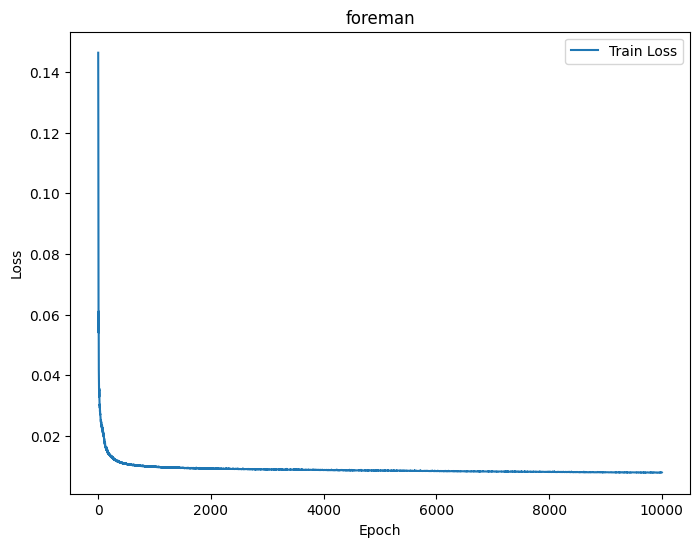


---------------------------flowers---------------------------


iteration no.: 0 ,loss : 0.121004
iteration no.: 500 ,loss : 0.014493
iteration no.: 1000 ,loss : 0.012462
iteration no.: 1500 ,loss : 0.011547
iteration no.: 2000 ,loss : 0.010902
iteration no.: 2500 ,loss : 0.010660
iteration no.: 3000 ,loss : 0.010224
iteration no.: 3500 ,loss : 0.009962
iteration no.: 4000 ,loss : 0.009861
iteration no.: 4500 ,loss : 0.009609
iteration no.: 5000 ,loss : 0.009441
iteration no.: 5500 ,loss : 0.009349
iteration no.: 6000 ,loss : 0.009213
iteration no.: 6500 ,loss : 0.009119
iteration no.: 7000 ,loss : 0.009040
iteration no.: 7500 ,loss : 0.008881
iteration no.: 8000 ,loss : 0.008823
iteration no.: 8500 ,loss : 0.008794
iteration no.: 9000 ,loss : 0.008642
iteration no.: 9500 ,loss : 0.008676
iteration no.: 10000 ,loss : 0.008607


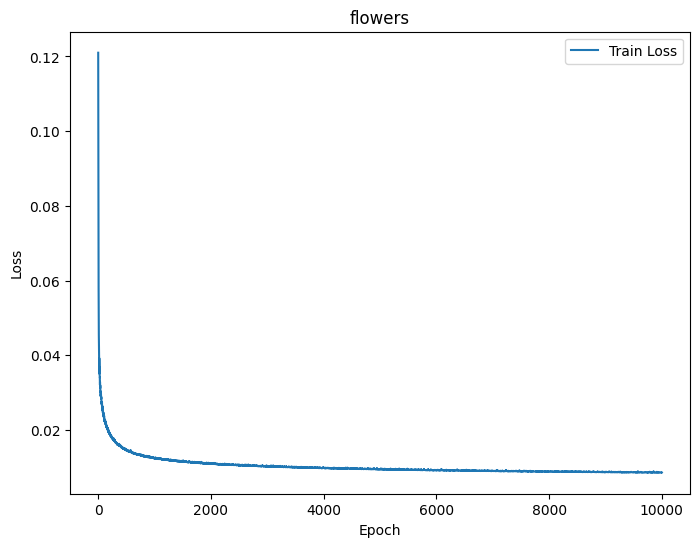


---------------------------baboon---------------------------


iteration no.: 0 ,loss : 0.106152
iteration no.: 500 ,loss : 0.020738
iteration no.: 1000 ,loss : 0.018673
iteration no.: 1500 ,loss : 0.017639
iteration no.: 2000 ,loss : 0.016867
iteration no.: 2500 ,loss : 0.016324
iteration no.: 3000 ,loss : 0.015868
iteration no.: 3500 ,loss : 0.015533
iteration no.: 4000 ,loss : 0.015174
iteration no.: 4500 ,loss : 0.014903
iteration no.: 5000 ,loss : 0.014643
iteration no.: 5500 ,loss : 0.014511
iteration no.: 6000 ,loss : 0.014227
iteration no.: 6500 ,loss : 0.014049
iteration no.: 7000 ,loss : 0.013948
iteration no.: 7500 ,loss : 0.013714
iteration no.: 8000 ,loss : 0.013598
iteration no.: 8500 ,loss : 0.013486
iteration no.: 9000 ,loss : 0.013379
iteration no.: 9500 ,loss : 0.013230
iteration no.: 10000 ,loss : 0.013190


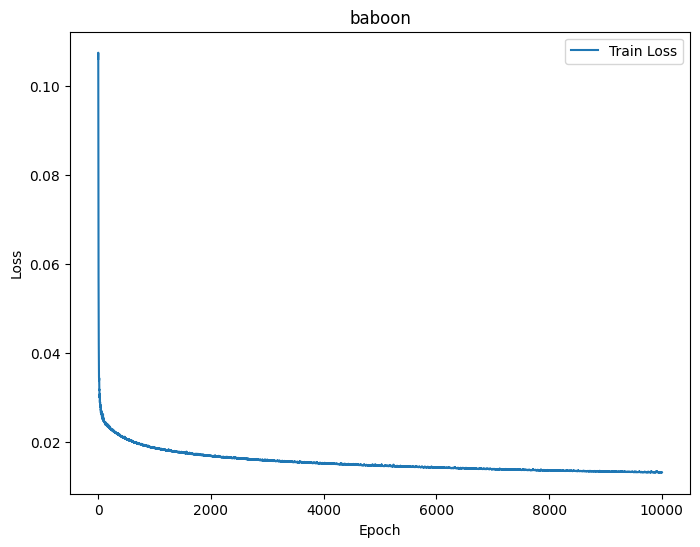


---------------------------man---------------------------


iteration no.: 0 ,loss : 0.144838
iteration no.: 500 ,loss : 0.013652
iteration no.: 1000 ,loss : 0.011927
iteration no.: 1500 ,loss : 0.011197
iteration no.: 2000 ,loss : 0.010780
iteration no.: 2500 ,loss : 0.010747
iteration no.: 3000 ,loss : 0.010399
iteration no.: 3500 ,loss : 0.010210
iteration no.: 4000 ,loss : 0.010012
iteration no.: 4500 ,loss : 0.009983
iteration no.: 5000 ,loss : 0.009874
iteration no.: 5500 ,loss : 0.009659
iteration no.: 6000 ,loss : 0.009584
iteration no.: 6500 ,loss : 0.009525
iteration no.: 7000 ,loss : 0.009429
iteration no.: 7500 ,loss : 0.009491
iteration no.: 8000 ,loss : 0.009349
iteration no.: 8500 ,loss : 0.009196
iteration no.: 9000 ,loss : 0.009193
iteration no.: 9500 ,loss : 0.009183
iteration no.: 10000 ,loss : 0.009156


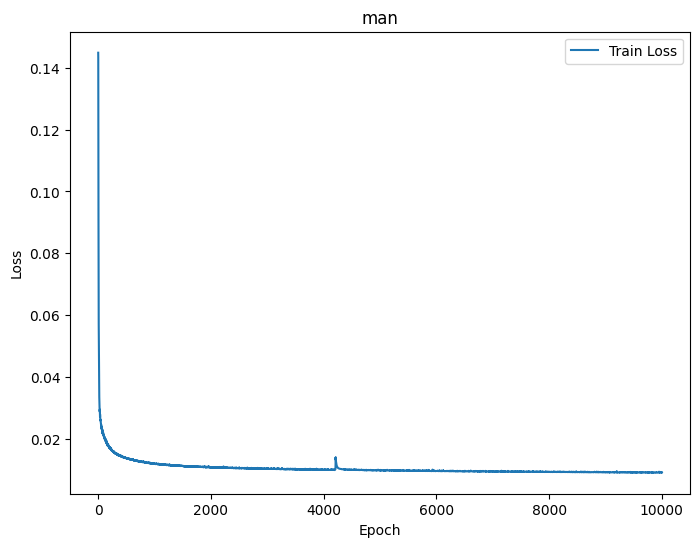


---------------------------lenna---------------------------


iteration no.: 0 ,loss : 0.105508
iteration no.: 500 ,loss : 0.011482
iteration no.: 1000 ,loss : 0.010694
iteration no.: 1500 ,loss : 0.010397
iteration no.: 2000 ,loss : 0.010156
iteration no.: 2500 ,loss : 0.009915
iteration no.: 3000 ,loss : 0.009842
iteration no.: 3500 ,loss : 0.009678
iteration no.: 4000 ,loss : 0.009606
iteration no.: 4500 ,loss : 0.009513
iteration no.: 5000 ,loss : 0.009458
iteration no.: 5500 ,loss : 0.009395
iteration no.: 6000 ,loss : 0.009270
iteration no.: 6500 ,loss : 0.009196
iteration no.: 7000 ,loss : 0.009148
iteration no.: 7500 ,loss : 0.009195
iteration no.: 8000 ,loss : 0.009008
iteration no.: 8500 ,loss : 0.008998
iteration no.: 9000 ,loss : 0.008923
iteration no.: 9500 ,loss : 0.008867
iteration no.: 10000 ,loss : 0.008800


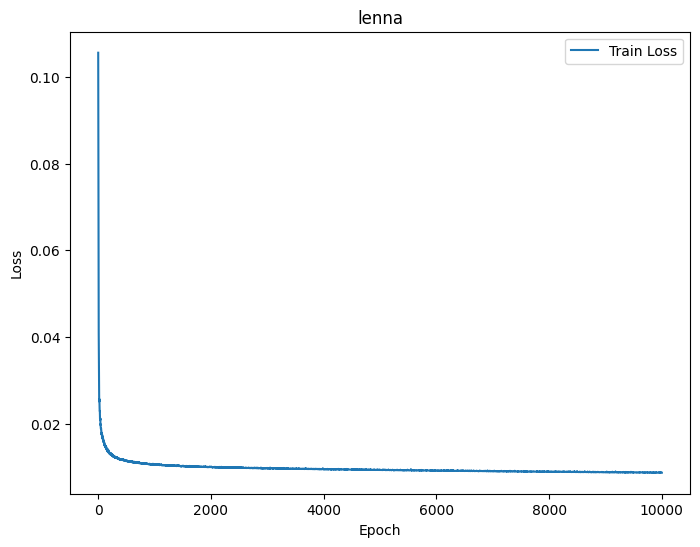


---------------------------ppt3---------------------------


iteration no.: 0 ,loss : 0.176899
iteration no.: 500 ,loss : 0.014453
iteration no.: 1000 ,loss : 0.010668
iteration no.: 1500 ,loss : 0.009325
iteration no.: 2000 ,loss : 0.008466
iteration no.: 2500 ,loss : 0.008071
iteration no.: 3000 ,loss : 0.007733
iteration no.: 3500 ,loss : 0.007539
iteration no.: 4000 ,loss : 0.007311
iteration no.: 4500 ,loss : 0.007117
iteration no.: 5000 ,loss : 0.007046
iteration no.: 5500 ,loss : 0.006924
iteration no.: 6000 ,loss : 0.006866
iteration no.: 6500 ,loss : 0.006772
iteration no.: 7000 ,loss : 0.006725
iteration no.: 7500 ,loss : 0.006686
iteration no.: 8000 ,loss : 0.006616
iteration no.: 8500 ,loss : 0.006548
iteration no.: 9000 ,loss : 0.006517
iteration no.: 9500 ,loss : 0.006469
iteration no.: 10000 ,loss : 0.006458


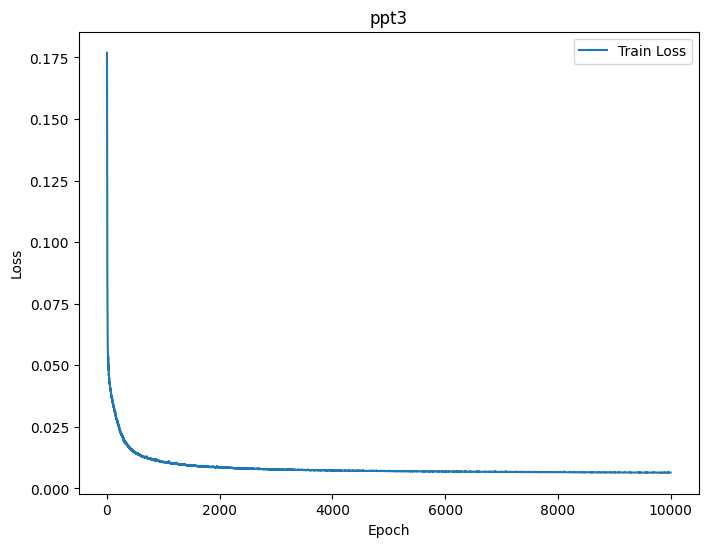


---------------------------monarch---------------------------


iteration no.: 0 ,loss : 0.113557
iteration no.: 500 ,loss : 0.012829
iteration no.: 1000 ,loss : 0.011149
iteration no.: 1500 ,loss : 0.010506
iteration no.: 2000 ,loss : 0.010175
iteration no.: 2500 ,loss : 0.009993
iteration no.: 3000 ,loss : 0.009863
iteration no.: 3500 ,loss : 0.009748
iteration no.: 4000 ,loss : 0.009713
iteration no.: 4500 ,loss : 0.009618
iteration no.: 5000 ,loss : 0.009592
iteration no.: 5500 ,loss : 0.009478
iteration no.: 6000 ,loss : 0.009423
iteration no.: 6500 ,loss : 0.009309
iteration no.: 7000 ,loss : 0.009290
iteration no.: 7500 ,loss : 0.009258
iteration no.: 8000 ,loss : 0.009184
iteration no.: 8500 ,loss : 0.009110
iteration no.: 9000 ,loss : 0.009085
iteration no.: 9500 ,loss : 0.009042
iteration no.: 10000 ,loss : 0.008999


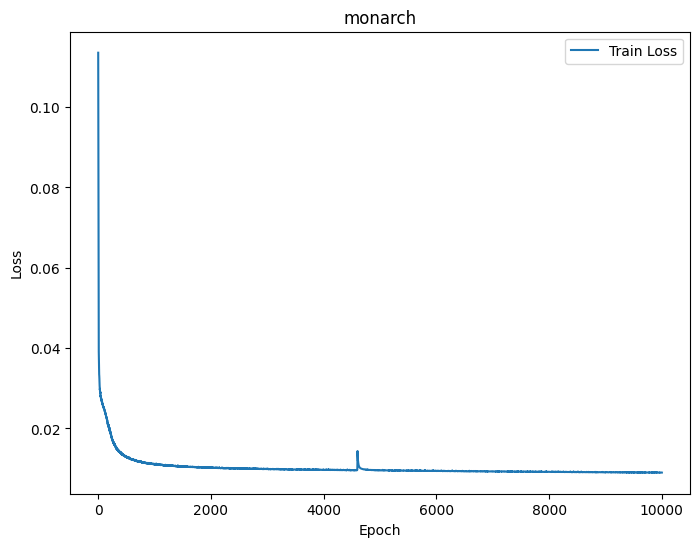


---------------------------zebra---------------------------


iteration no.: 0 ,loss : 0.103884
iteration no.: 500 ,loss : 0.014576
iteration no.: 1000 ,loss : 0.012238
iteration no.: 1500 ,loss : 0.011180
iteration no.: 2000 ,loss : 0.010682
iteration no.: 2500 ,loss : 0.010307
iteration no.: 3000 ,loss : 0.010086
iteration no.: 3500 ,loss : 0.009998
iteration no.: 4000 ,loss : 0.009658
iteration no.: 4500 ,loss : 0.009536
iteration no.: 5000 ,loss : 0.009319
iteration no.: 5500 ,loss : 0.009272
iteration no.: 6000 ,loss : 0.009059
iteration no.: 6500 ,loss : 0.008961
iteration no.: 7000 ,loss : 0.008878
iteration no.: 7500 ,loss : 0.008864
iteration no.: 8000 ,loss : 0.008819
iteration no.: 8500 ,loss : 0.008686
iteration no.: 9000 ,loss : 0.008608
iteration no.: 9500 ,loss : 0.008530
iteration no.: 10000 ,loss : 0.008508


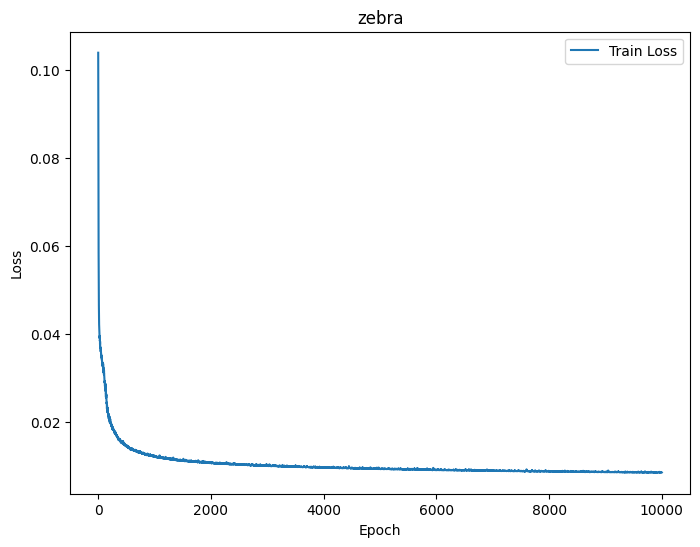


---------------------------barbara---------------------------


iteration no.: 0 ,loss : 0.096579
iteration no.: 500 ,loss : 0.015408
iteration no.: 1000 ,loss : 0.013598
iteration no.: 1500 ,loss : 0.012872
iteration no.: 2000 ,loss : 0.012593
iteration no.: 2500 ,loss : 0.012382
iteration no.: 3000 ,loss : 0.012124
iteration no.: 3500 ,loss : 0.011970
iteration no.: 4000 ,loss : 0.011830
iteration no.: 4500 ,loss : 0.011716
iteration no.: 5000 ,loss : 0.011576


In [ ]:
for image in file_list:
  # image_path = 'zebra.png'
  ## experiment options
  sigma = 1. / 30
  method = 'random'
  input_channel = 3
  lr = 0.01
  num_iter = 10000

  ### load data
  img = load_img(image)
  x = ChangeImage(img)
  x = add_noise(x,25 / 255.)
  words = image.split('/')
  imm = words[-1].split('.')[0]
  full_path = './drive/MyDrive/SMAI_Project/{}'.format(imm)
  try:
    os.mkdir(full_path) 
  except OSError as error: 
    print(error)  
  # os.mkdir(imm)
  print("\n---------------------------{}---------------------------".format(imm))
  array_to_img(x[0]).save('{}/noise.png'.format(full_path))
  layers = model_obj(x)
  b, w, h, c = x.shape
  model = layers.model_structure()
  model.compile(optimizer=Adam(lr=lr), loss=mse)
  # model.summary()

  num_iter = 10000
  train_loss = []
  z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
  losses = []
  for i in range(num_iter+1):
      with tf.device('/GPU:0'):
        temp = z + np.random.normal(0, sigma, size = z.shape)
        loss = model.train_on_batch(temp, x)
        train_loss.append(loss)
        if i % 500 == 0:
            print('iteration no.: %d ,loss : %f' % (i, loss))
            y = model.predict_on_batch(z)
            array_to_img(y[0]).save('{}/{}.png'.format(full_path, i))

  plot_losses(train_loss, imm)

In [ ]:
#z = make_noise(method, input_channel, (w, h))
sigma = 1. / 30
method = 'random'
input_channel = 3
lr = 0.01
num_iter = 10000

image_path = "./drive/MyDrive/SMAI_Project/barbara.png"

### load data
img = load_img(image_path)
x = ChangeImage(img)
layers = model_obj(x)
b, w, h, c = x.shape
model = layers.model_structure()
model.compile(optimizer=Adam(lr=lr), loss=mse)


num_iter = 10000
z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
original_losses = []
for i in range(num_iter+1):
    with tf.device('/GPU:0'):
      temp = z + np.random.normal(0, sigma, size = z.shape)
      loss = model.train_on_batch(temp, x)
      original_losses.append(loss)
      if i % 500 == 0:
          print('iteration no.: %d ,loss : %f' % (i, loss))
          y = model.predict_on_batch(z)
          array_to_img(y[0]).save('./drive/MyDrive/SMAI_Project/comparison/original/%d.png' % i)

iteration no.: 0 ,loss : 0.081563
iteration no.: 500 ,loss : 0.006060
iteration no.: 1000 ,loss : 0.004354
iteration no.: 1500 ,loss : 0.003828
iteration no.: 2000 ,loss : 0.003572
iteration no.: 2500 ,loss : 0.003392
iteration no.: 3000 ,loss : 0.003226
iteration no.: 3500 ,loss : 0.003062
iteration no.: 4000 ,loss : 0.002939
iteration no.: 4500 ,loss : 0.002834
iteration no.: 5000 ,loss : 0.002737
iteration no.: 5500 ,loss : 0.002696
iteration no.: 6000 ,loss : 0.002619
iteration no.: 6500 ,loss : 0.002625
iteration no.: 7000 ,loss : 0.002535
iteration no.: 7500 ,loss : 0.002499
iteration no.: 8000 ,loss : 0.002494
iteration no.: 8500 ,loss : 0.002443
iteration no.: 9000 ,loss : 0.002441
iteration no.: 9500 ,loss : 0.002410
iteration no.: 10000 ,loss : 0.002387


In [ ]:
sigma = 1. / 30
method = 'random'
input_channel = 3
lr = 0.01
num_iter = 10000

image_path = "./drive/MyDrive/SMAI_Project/barbara.png"

### load data
img = load_img(image_path)
y = ChangeImage(img)
y = add_noise(y,25 / 255.)
array_to_img(y[0]).save('./drive/MyDrive/SMAI_Project/comparison/barbara_noise.png')
layers = model_obj(y)
b, w, h, c = y.shape
model = layers.model_structure()
model.compile(optimizer=Adam(lr=lr), loss=mse)


num_iter = 10000
z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
noise_losses = []
for i in range(num_iter+1):
    with tf.device('/GPU:0'):
      temp = z + np.random.normal(0, sigma, size = z.shape)
      loss = model.train_on_batch(temp, y)
      noise_losses.append(loss)
      if i % 500 == 0:
          print('iteration no.: %d ,loss : %f' % (i, loss))
          a = model.predict_on_batch(z)
          array_to_img(a[0]).save('./drive/MyDrive/SMAI_Project/comparison/noisy/%d.png' % i)

iteration no.: 0 ,loss : 0.083623
iteration no.: 500 ,loss : 0.015267
iteration no.: 1000 ,loss : 0.013423
iteration no.: 1500 ,loss : 0.012862
iteration no.: 2000 ,loss : 0.012608
iteration no.: 2500 ,loss : 0.012370
iteration no.: 3000 ,loss : 0.012082
iteration no.: 3500 ,loss : 0.011910
iteration no.: 4000 ,loss : 0.011836
iteration no.: 4500 ,loss : 0.011672
iteration no.: 5000 ,loss : 0.011723
iteration no.: 5500 ,loss : 0.011525
iteration no.: 6000 ,loss : 0.011373
iteration no.: 6500 ,loss : 0.011337
iteration no.: 7000 ,loss : 0.011260
iteration no.: 7500 ,loss : 0.011154
iteration no.: 8000 ,loss : 0.011173
iteration no.: 8500 ,loss : 0.011097
iteration no.: 9000 ,loss : 0.011044
iteration no.: 9500 ,loss : 0.011047
iteration no.: 10000 ,loss : 0.010958


In [ ]:
def plot_comparative_losses(original_loss, noisy_loss, image_title):
    plt.figure(figsize=(8, 6))
    plt.title(image_title)
    plt.plot(original_loss, label='Image')
    plt.plot(noisy_loss, label='Image + Noise')
    plt.xlabel('Iteration (Log Scale)')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

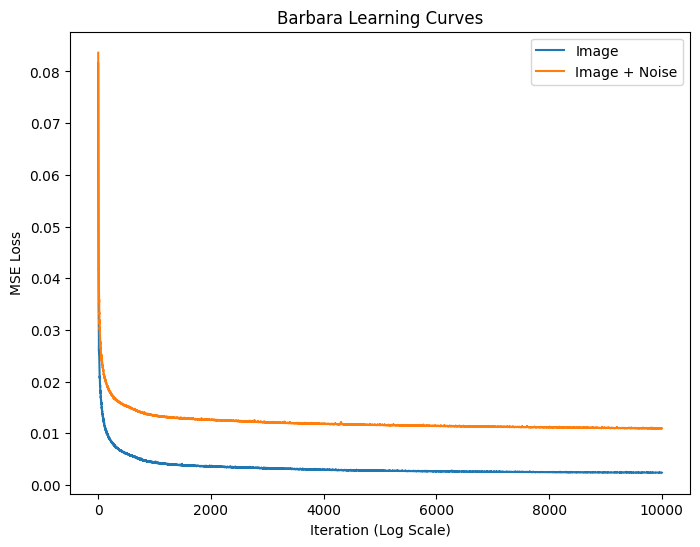

In [ ]:
plot_comparative_losses(original_losses, noise_losses, "Barbara Learning Curves")